In [1]:
import urllib.request as request
import os
import subprocess
from IPython.display import Image


In [12]:
def execute_shell_command(cmd):
    """Execute a shell command and return the output as a byte string."""
    return subprocess.check_output(cmd, shell=True)

In [2]:
#######################################
### Downloading MSigDB gene sets. #####
### Version: 2023.1 ###################
#######################################


# download to a file

import requests

def download_file(url, filename):
    
    if os.path.exists(filename):
        print(f"{filename} already exists")
        return
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537'
    }
    response = requests.get(url, headers=headers, stream=True)
    
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
        print(f"{filename} downloaded successfully")
    else:
        print(f"Failed to download {filename}. Status code: {response.status_code}")




separate_databases = {
    "biocarta" : "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/c2.cp.biocarta.v2023.1.Hs.symbols.gmt",
    "kegg": "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/c2.cp.kegg.v2023.1.Hs.symbols.gmt",
    "pid": "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/c2.cp.pid.v2023.1.Hs.symbols.gmt",
    "reactome": "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/c2.cp.reactome.v2023.1.Hs.symbols.gmt",
    "wikipathways": "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/c2.cp.wikipathways.v2023.1.Hs.symbols.gmt"
}

# download all
download_directory = "raw_data"
# create the directory if it does not exist
if not os.path.exists(download_directory): os.makedirs(download_directory)
for name, url in separate_databases.items():
    file_path = os.path.join(download_directory, f"{name}.gmt")
    download_file(url, file_path)

# download the all canonical pathways
# download_file("https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/c2.cp.v2023.1.Hs.symbols.gmt", "canonical_pathways.gmt")

raw_data/biocarta.gmt already exists
raw_data/kegg.gmt already exists
raw_data/pid.gmt already exists
raw_data/reactome.gmt already exists
raw_data/wikipathways.gmt already exists


In [3]:
from glob import glob
all_gmts = glob(f"{download_directory}/*.gmt")
gmt_prefix_to_gmt_file = {os.path.splitext(os.path.basename(gmt))[0]: gmt for gmt in all_gmts}
print(f"Loaded gmts: {gmt_prefix_to_gmt_file}")

Loaded gmts: {'reactome': 'raw_data/reactome.gmt', 'wikipathways': 'raw_data/wikipathways.gmt', 'kegg': 'raw_data/kegg.gmt', 'pid': 'raw_data/pid.gmt', 'biocarta': 'raw_data/biocarta.gmt'}


# Expirement design
1. Index all GMTs in the database
2. From the pairwise, we will know the within/across-db overlap.

The problem here is the we need to separate the within-db and across-db overlap.

In [15]:
gmt_parameters = ' '.join([f"--gmt {gmt}" for gmt in all_gmts])

In [16]:
# Index all of them
!DBRetina index $gmt_parameters -o idx_all

[INFO] Processing raw_data/reactome.gmt
[INFO] Processing raw_data/wikipathways.gmt
[INFO] Processing raw_data/kegg.gmt
[INFO] Processing raw_data/pid.gmt
[INFO] Processing raw_data/biocarta.gmt
[INFO] Sketching in progress, please wait...
[SUCCESS] File(s) has been sketched.
[INFO] Indexing in progress, please wait...
[dev] Total number of colors: 10791
[dev] Total selected colors: 8302
[dev] Average color size: 11.4344
[dev] Color size standard deviation: 687.09
[SUCCESS] DONE!


In [17]:
# Perform pairwise comparisons
!DBRetina pairwise -i idx_all -t 8

[INFO] Constructing the pairwise matrix using 8 cores.
population_size: 44260
[dev] mapping colors to groups: 5.54e-05 secs
[dev] parsing index colors: 0.0007118 secs
[dev] features counting: 0.0015319 secs
[dev] number of colors = 8302
[dev] average color size = 14
[dev] pairwise hashmap construction: 0.207543 secs
[dev] Number of pairwise comparisons: 761984
[dev] writing pairwise matrix to idx_all_DBRetina_pairwise.tsv | Please wait...
[INFO] Plotting similarity metrics distribution to idx_all_DBRetina_similarity_metrics_plot_linear.png and idx_all_DBRetina_similarity_metrics_plot_log.png
[SUCCESS] Done.


In [14]:
# print stats json
import json
def print_json(stats_json):
# load json idx_all_DBRetina_pairwise_stats.json
    with open(stats_json) as f:
        stats = json.load(f)
        for metric, stats in stats.items():
            print(f"Metric: {metric}")
            print(stats)

## Within & across databases overlap

In [16]:
# load json idx_all_DBRetina_pairwise_stats.json
print_json("idx_all_DBRetina_pairwise_stats.json")

Metric: containment
{'50-55': 9057, '55-60': 5925, '15-20': 64111, '70-75': 2847, '75-80': 2395, '90-95': 1478, '95-100': 277, '100-100': 5116, '25-30': 36487, '0-5': 197793, '80-85': 2579, '85-90': 2072, '30-35': 23303, '40-45': 16669, '45-50': 6057, '5-10': 192013, '60-65': 5244, '65-70': 3759, '35-40': 14462, '20-25': 47779, '10-15': 122561}
Metric: ochiai
{'50-55': 1866, '55-60': 1271, '15-20': 42735, '70-75': 551, '75-80': 433, '90-95': 94, '95-100': 12, '100-100': 5, '25-30': 13578, '0-5': 376847, '80-85': 337, '85-90': 225, '30-35': 7963, '40-45': 3426, '45-50': 2388, '5-10': 196136, '60-65': 1034, '65-70': 785, '35-40': 4898, '20-25': 23901, '10-15': 83499}
Metric: jaccard
{'50-55': 586, '55-60': 352, '15-20': 11416, '70-75': 185, '75-80': 127, '90-95': 6, '95-100': 6, '100-100': 5, '25-30': 3386, '0-5': 600804, '80-85': 111, '85-90': 24, '30-35': 1946, '40-45': 1013, '45-50': 649, '5-10': 102732, '60-65': 322, '65-70': 229, '35-40': 1334, '20-25': 5548, '10-15': 31203}


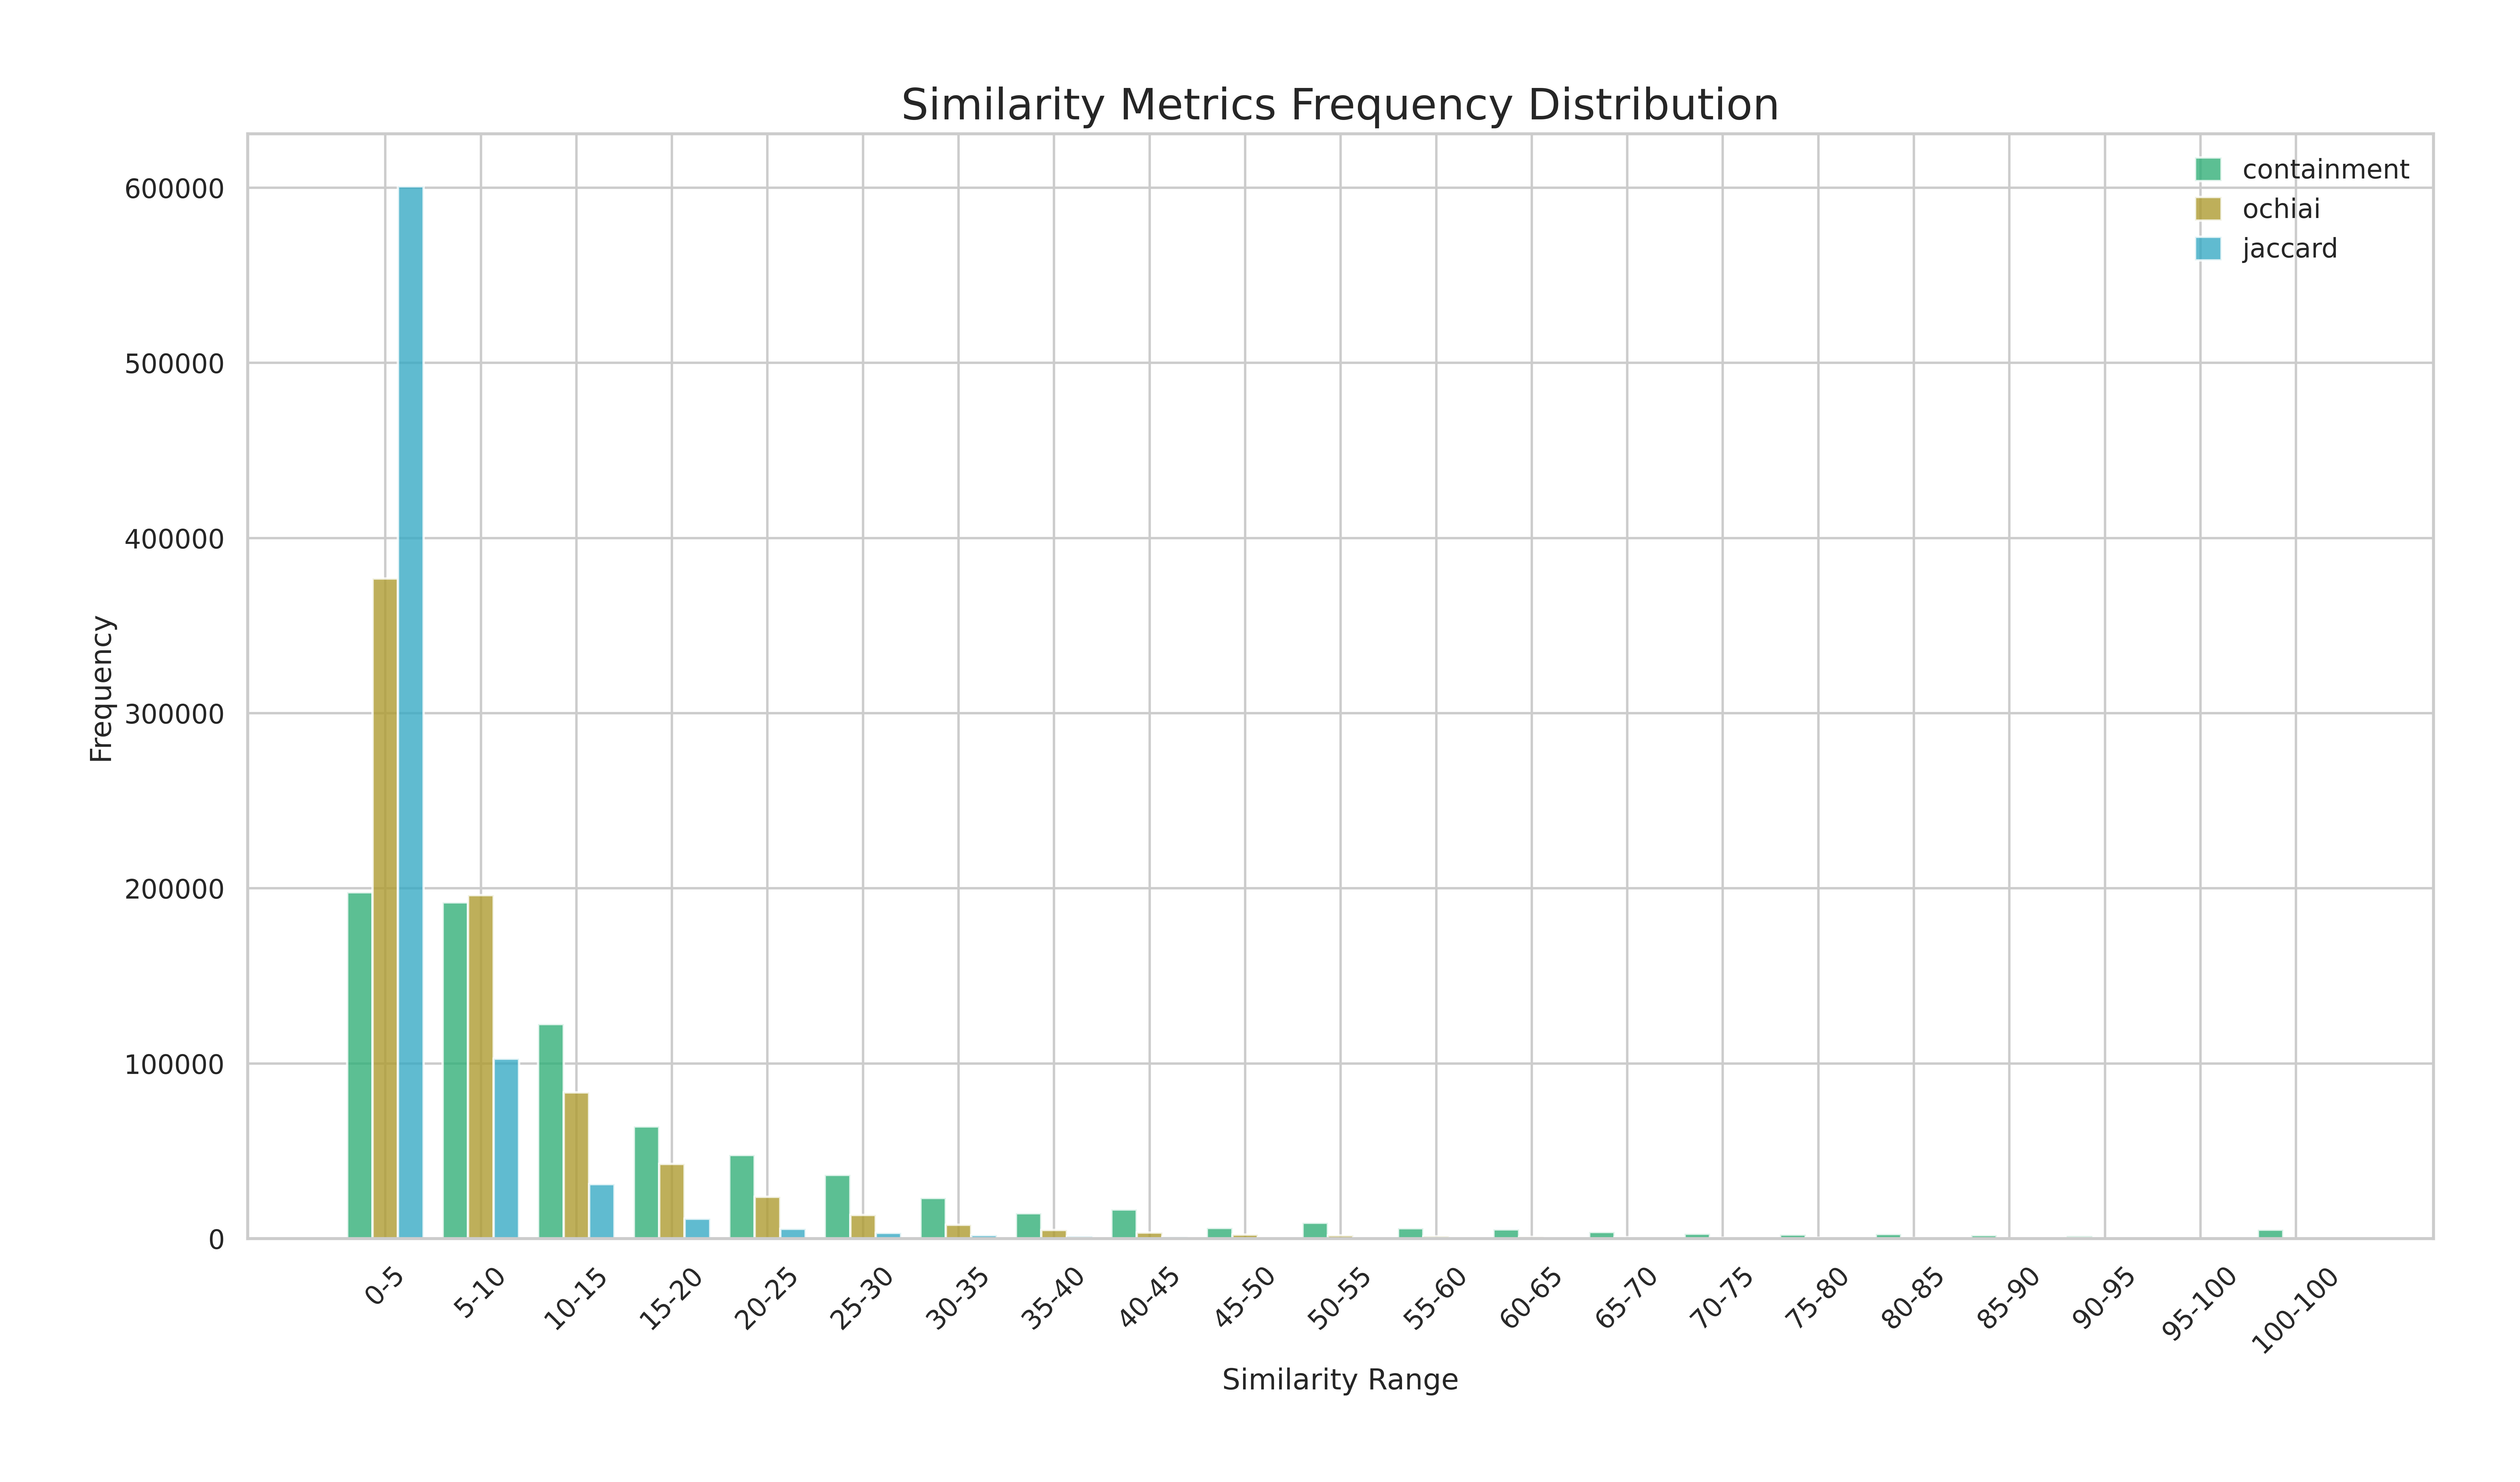

In [5]:
# View image
Image(filename='idx_all_DBRetina_similarity_metrics_plot_linear.png')

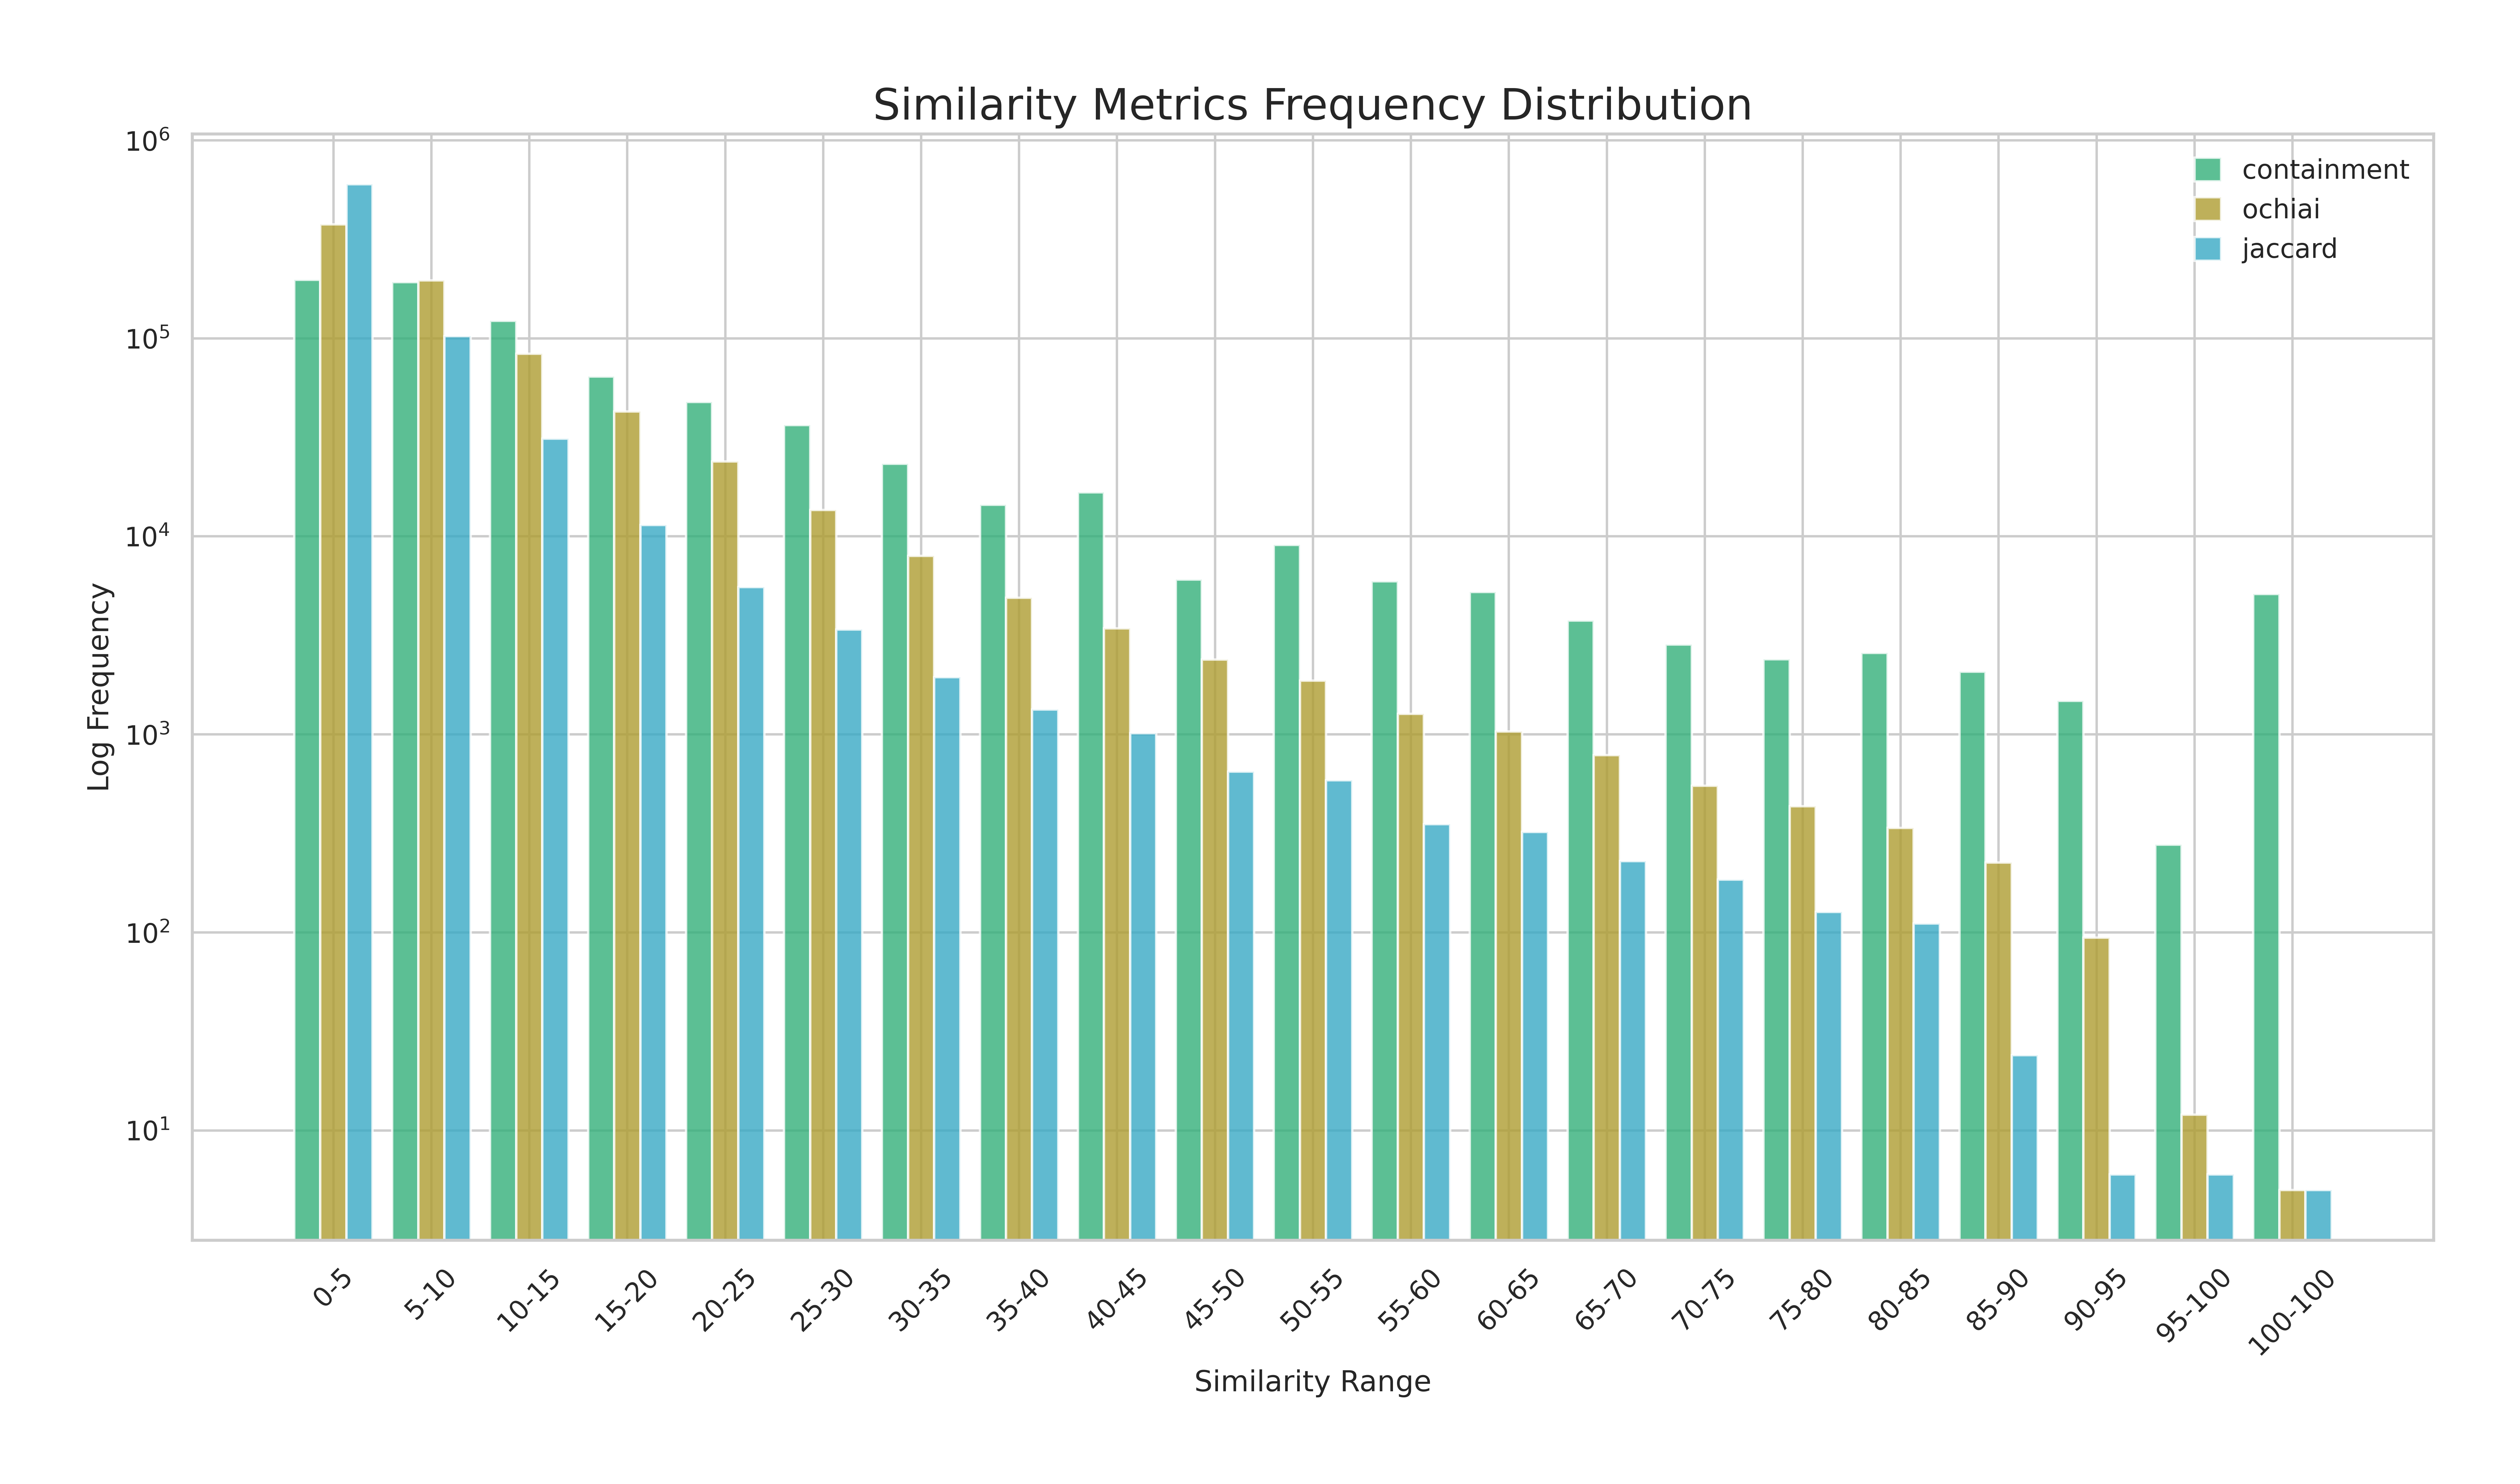

In [6]:
Image(filename='idx_all_DBRetina_similarity_metrics_plot_log.png')

#### Insights

<hr>

### Study overlap each database and all databases minus this database.

In [20]:
for db_name, gmt_file in gmt_prefix_to_gmt_file.items():
    gmts = set(gmt_prefix_to_gmt_file.values()) - {gmt_file}
    !rm -rf bipartite_$db_name
    !mkdir -p bipartite_$db_name
    for gmt in gmts:
        !cat {gmt} >> bipartite_$db_name/dbs.gmt
        !cp {gmt_file} bipartite_$db_name/db_name_query.gmt

In [4]:
for db_name, gmt_file in gmt_prefix_to_gmt_file.items():
    ! echo "running: DBRetina bipartite -p idx_all_DBRetina_pairwise.tsv --gmt1 $gmt_file --gmt2 bipartite_$db_name/dbs.gmt -o bipartite_$db_name/bipartite_$db_name"
    !DBRetina bipartite -p idx_all_DBRetina_pairwise.tsv --gmt1 $gmt_file --gmt2 bipartite_$db_name/dbs.gmt -o bipartite_$db_name/bipartite_$db_name --metric ochiai --no-plot


running: DBRetina bipartite -p idx_all_DBRetina_pairwise.tsv --gmt1 raw_data/reactome.gmt --gmt2 bipartite_reactome/dbs.gmt -o bipartite_reactome/bipartite_reactome
[INFO] Parsing the two group files...
[INFO] Parsing the pairwise file...
[INFO] Writing the bipartite TSV file to bipartite_reactome/bipartite_reactome_bipartite_pairwise.tsv
[INFO] Plotting the similarity metrics histogram to bipartite_reactome/bipartite_reactome_similarity_metrics_histogram.png
[INFO] Writing the similarity metrics histogram to bipartite_reactome/bipartite_reactome_similarity_metrics_histogram.json
[INFO] Plotting the similarity metrics histogram (log-scale) to bipartite_reactome/bipartite_reactome_similarity_metrics_histogram_log.png
[WARNING] Missing gene set names detected, reporting to bipartite_reactome/bipartite_reactome_missing_groups.txt
running: DBRetina bipartite -p idx_all_DBRetina_pairwise.tsv --gmt1 raw_data/wikipathways.gmt --gmt2 bipartite_wikipathways/dbs.gmt -o bipartite_wikipathways/bip

### WikiPathways vs all databases minus WikiPathways

Metric: containment
{'0-5': 86053, '5-10': 78192, '10-15': 46197, '15-20': 23206, '20-25': 17588, '25-30': 11987, '30-35': 7833, '35-40': 4666, '40-45': 4922, '45-50': 1782, '50-55': 2783, '55-60': 1436, '60-65': 1395, '65-70': 948, '70-75': 594, '75-80': 499, '80-85': 505, '85-90': 322, '90-95': 203, '95-100': 41, '100-100': 338}
Metric: ochiai
{'0-5': 155792, '5-10': 75397, '10-15': 29944, '15-20': 14644, '20-25': 7525, '25-30': 3868, '30-35': 1969, '35-40': 949, '40-45': 558, '45-50': 315, '50-55': 199, '55-60': 107, '60-65': 67, '65-70': 45, '70-75': 25, '75-80': 26, '80-85': 19, '85-90': 16, '90-95': 15, '95-100': 8, '100-100': 2}
Metric: jaccard
{'0-5': 240537, '5-10': 36292, '10-15': 9593, '15-20': 2939, '20-25': 1039, '25-30': 498, '30-35': 218, '35-40': 130, '40-45': 70, '45-50': 44, '50-55': 36, '55-60': 13, '60-65': 23, '65-70': 13, '70-75': 8, '75-80': 7, '80-85': 13, '85-90': 7, '90-95': 2, '95-100': 6, '100-100': 2}


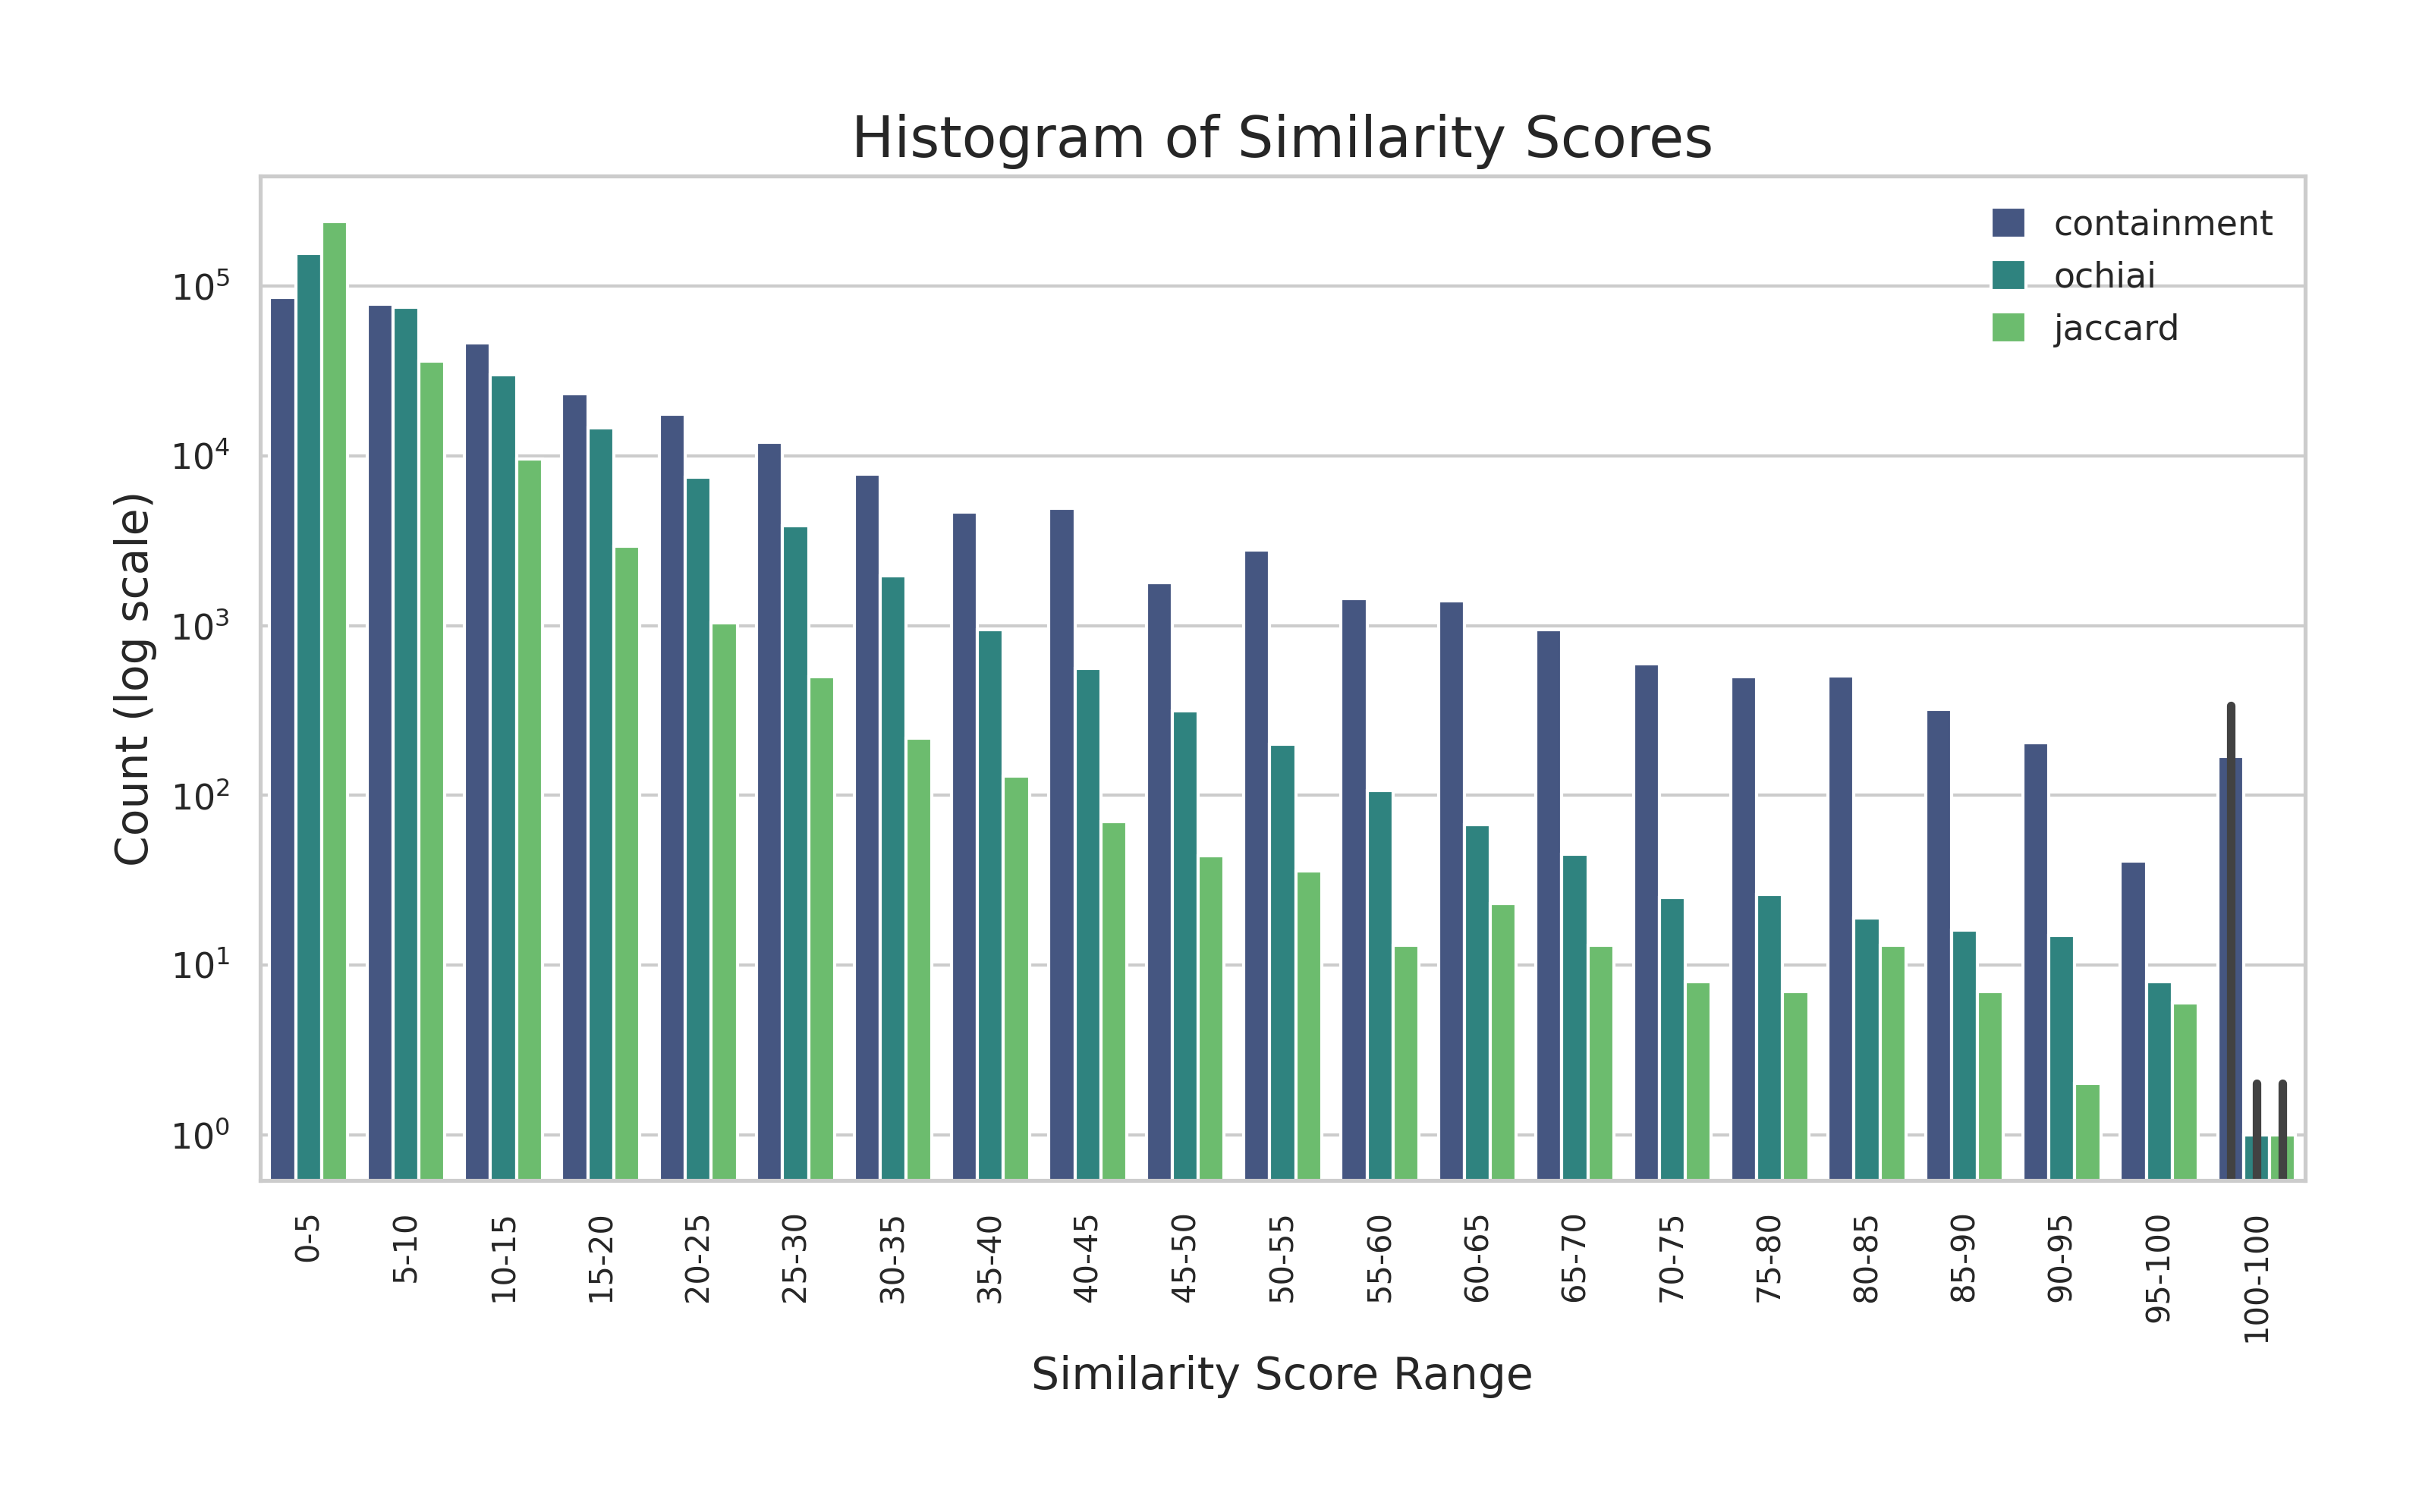

In [18]:
print_json("bipartite_wikipathways/bipartite_wikipathways_similarity_metrics_histogram.json")

Image(filename='bipartite_wikipathways/bipartite_wikipathways_similarity_metrics_histogram_log.png')

### Reactome vs all databases minus Reactome

Metric: containment
{'0-5': 102215, '5-10': 89469, '10-15': 54818, '15-20': 26714, '20-25': 20473, '25-30': 14454, '30-35': 8963, '35-40': 5170, '40-45': 6132, '45-50': 1985, '50-55': 3424, '55-60': 1704, '60-65': 1905, '65-70': 1218, '70-75': 949, '75-80': 628, '80-85': 823, '85-90': 504, '90-95': 378, '95-100': 63, '100-100': 504}
Metric: ochiai
{'0-5': 189537, '5-10': 87368, '10-15': 32954, '15-20': 15529, '20-25': 8104, '25-30': 4137, '30-35': 2120, '35-40': 1101, '40-45': 638, '45-50': 364, '50-55': 232, '55-60': 138, '60-65': 95, '65-70': 69, '70-75': 32, '75-80': 29, '80-85': 25, '85-90': 13, '90-95': 7, '95-100': 0, '100-100': 1}
Metric: jaccard
{'0-5': 288730, '5-10': 38224, '10-15': 10125, '15-20': 3021, '20-25': 1129, '25-30': 567, '30-35': 248, '35-40': 152, '40-45': 101, '45-50': 61, '50-55': 51, '55-60': 14, '60-65': 25, '65-70': 17, '70-75': 9, '75-80': 3, '80-85': 12, '85-90': 3, '90-95': 0, '95-100': 0, '100-100': 1}


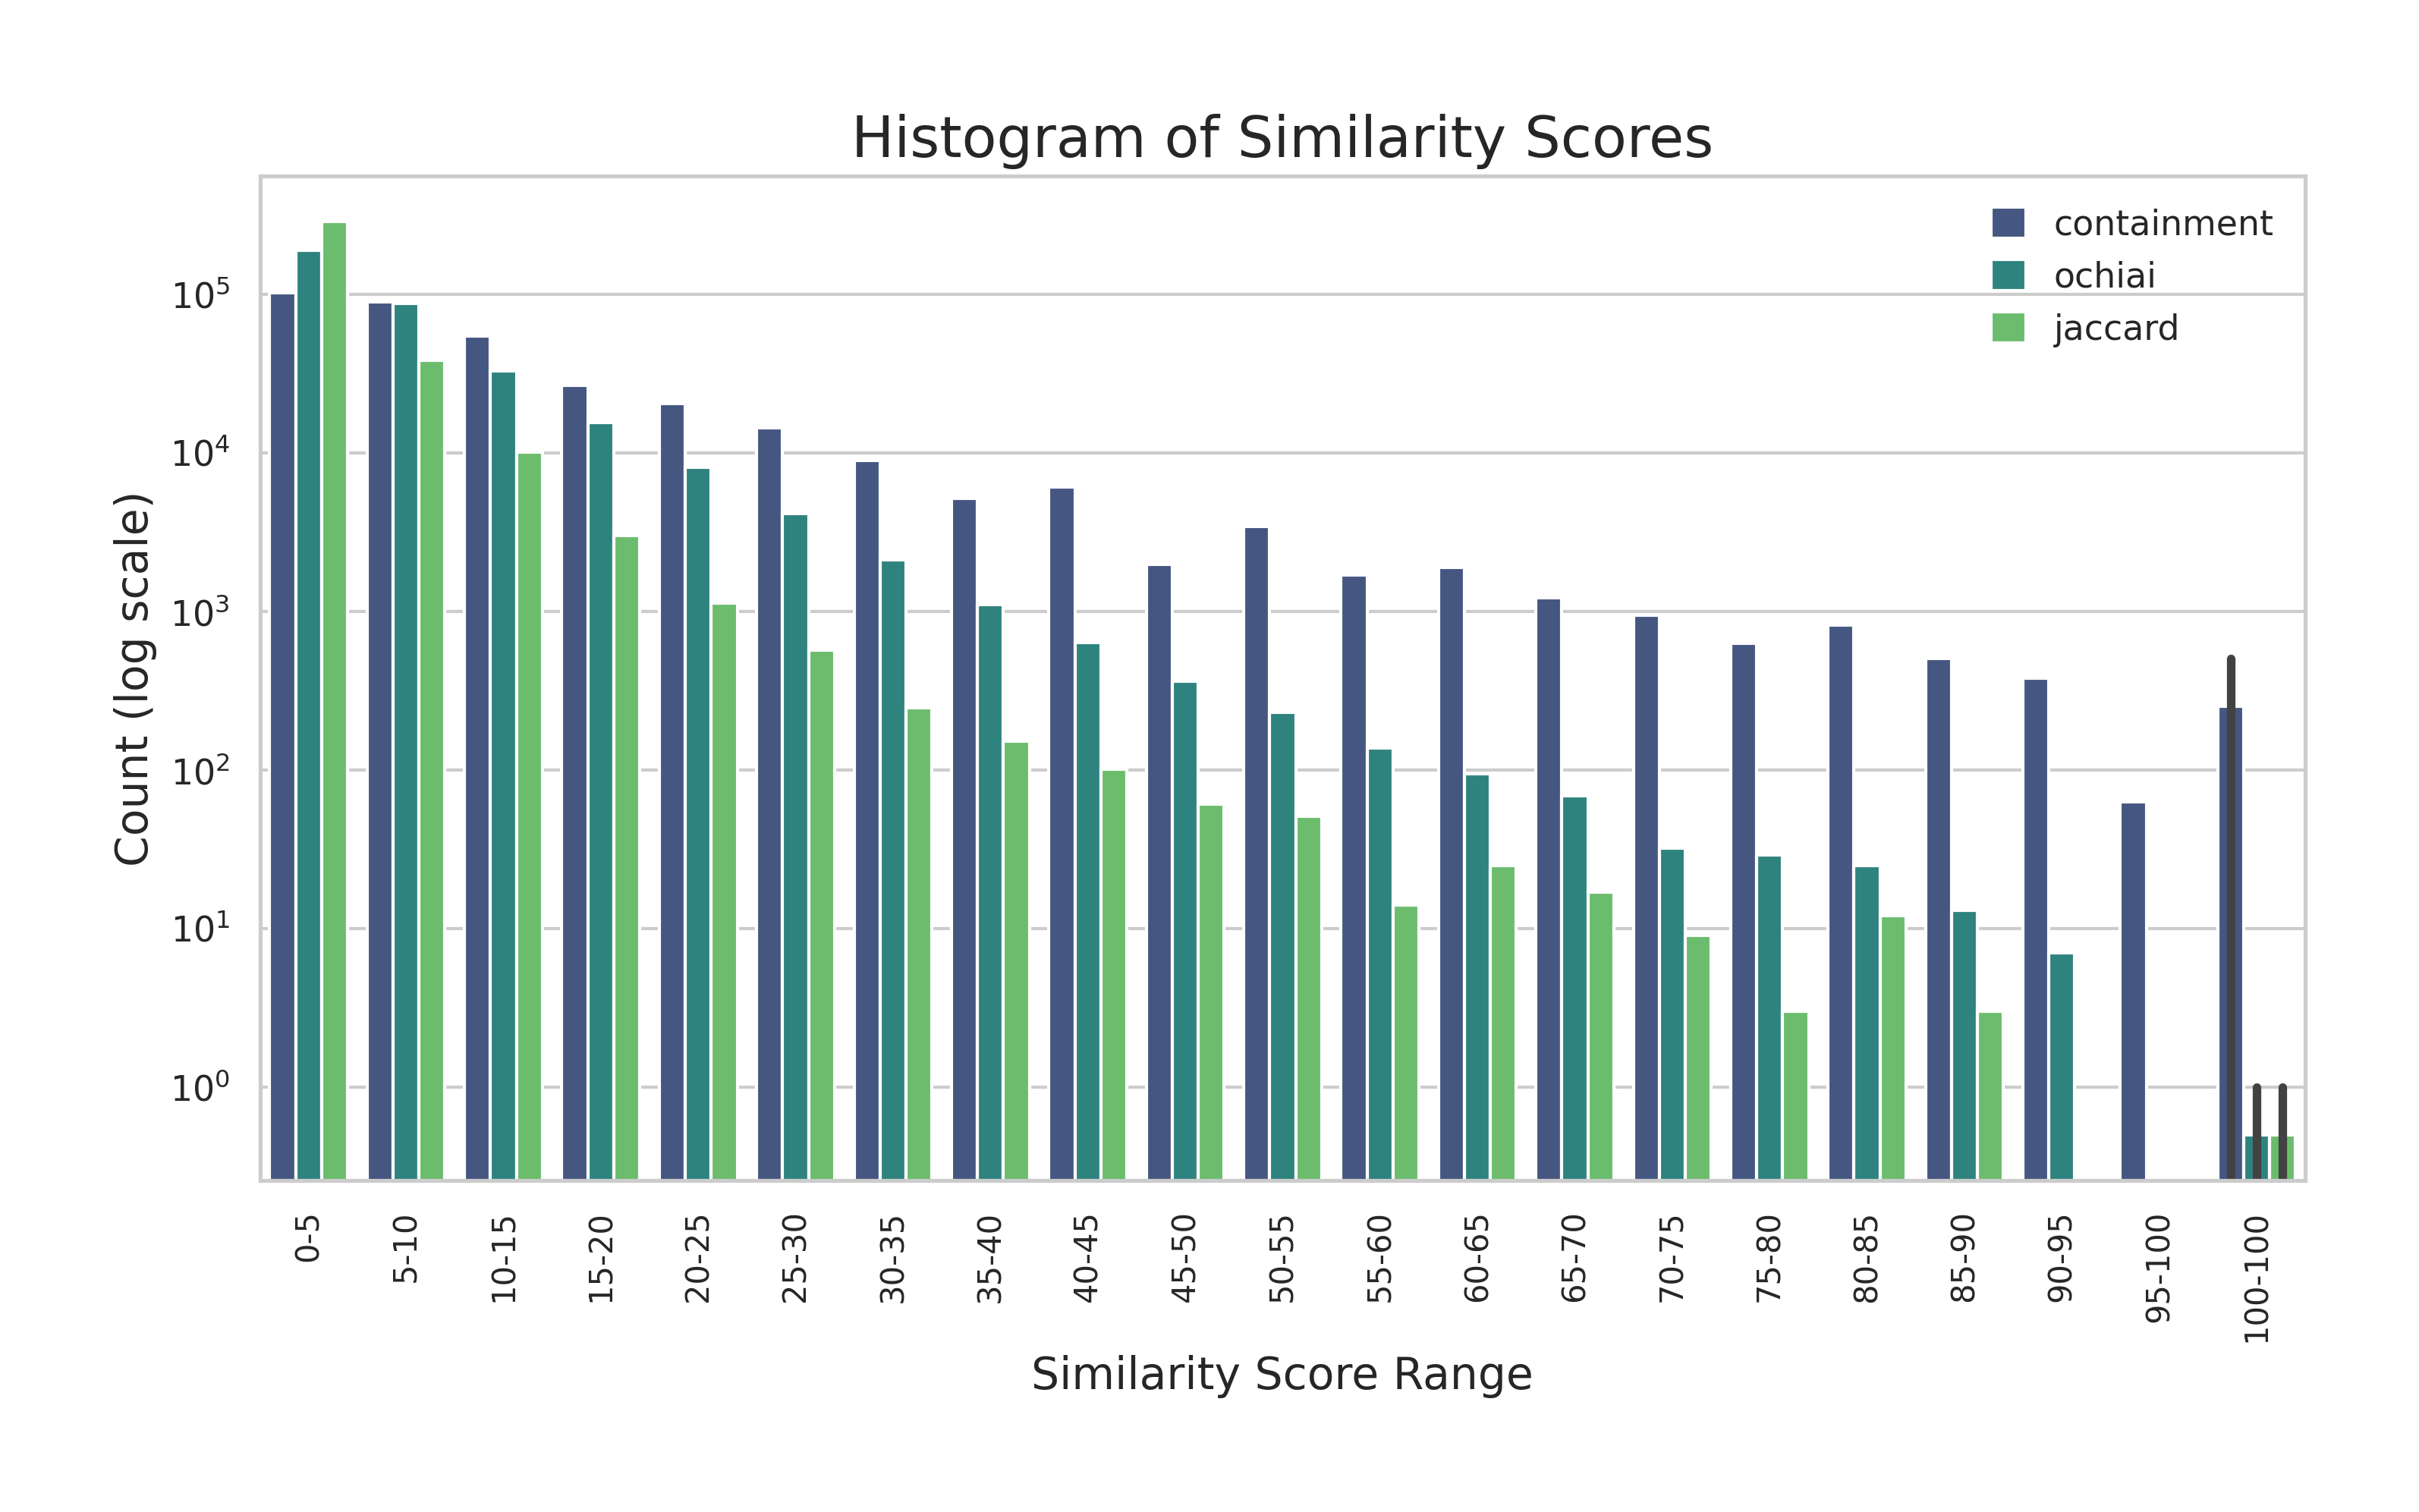

In [21]:
print_json("bipartite_reactome/bipartite_reactome_similarity_metrics_histogram.json")

Image(filename='bipartite_reactome/bipartite_reactome_similarity_metrics_histogram_log.png')

### PID vs all databases minus PID

Metric: containment
{'0-5': 43343.0, '5-10': 39988.0, '10-15': 23664.0, '15-20': 11995.0, '20-25': 8677.0, '25-30': 6058.0, '30-35': 3610.0, '35-40': 2232.0, '40-45': 2099.0, '45-50': 770.0, '50-55': 1030.0, '55-60': 545.0, '60-65': 441.0, '65-70': 286.0, '70-75': 178.0, '75-80': 126.0, '80-85': 138.0, '85-90': 45.0, '90-95': 40.0, '95-100': 8.0, '100-100': 64.0}
Metric: ochiai
{'0-5': 71853.0, '5-10': 40126.0, '10-15': 16764.0, '15-20': 8321.0, '20-25': 4262.0, '25-30': 2097.0, '30-35': 986.0, '35-40': 465.0, '40-45': 242.0, '45-50': 114.0, '50-55': 49.0, '55-60': 23.0, '60-65': 15.0, '65-70': 11.0, '70-75': 3.0, '75-80': 1.0, '80-85': 3.0, '85-90': 2.0, '90-95': 0.0, '95-100': 0.0, '100-100': nan}
Metric: jaccard
{'0-5': 115602.0, '5-10': 21417.0, '10-15': 5858.0, '15-20': 1586.0, '20-25': 536.0, '25-30': 200.0, '30-35': 66.0, '35-40': 32.0, '40-45': 18.0, '45-50': 10.0, '50-55': 4.0, '55-60': 2.0, '60-65': 1.0, '65-70': 3.0, '70-75': 0.0, '75-80': 1.0, '80-85': 1.0, '85-90': 0.0, '9

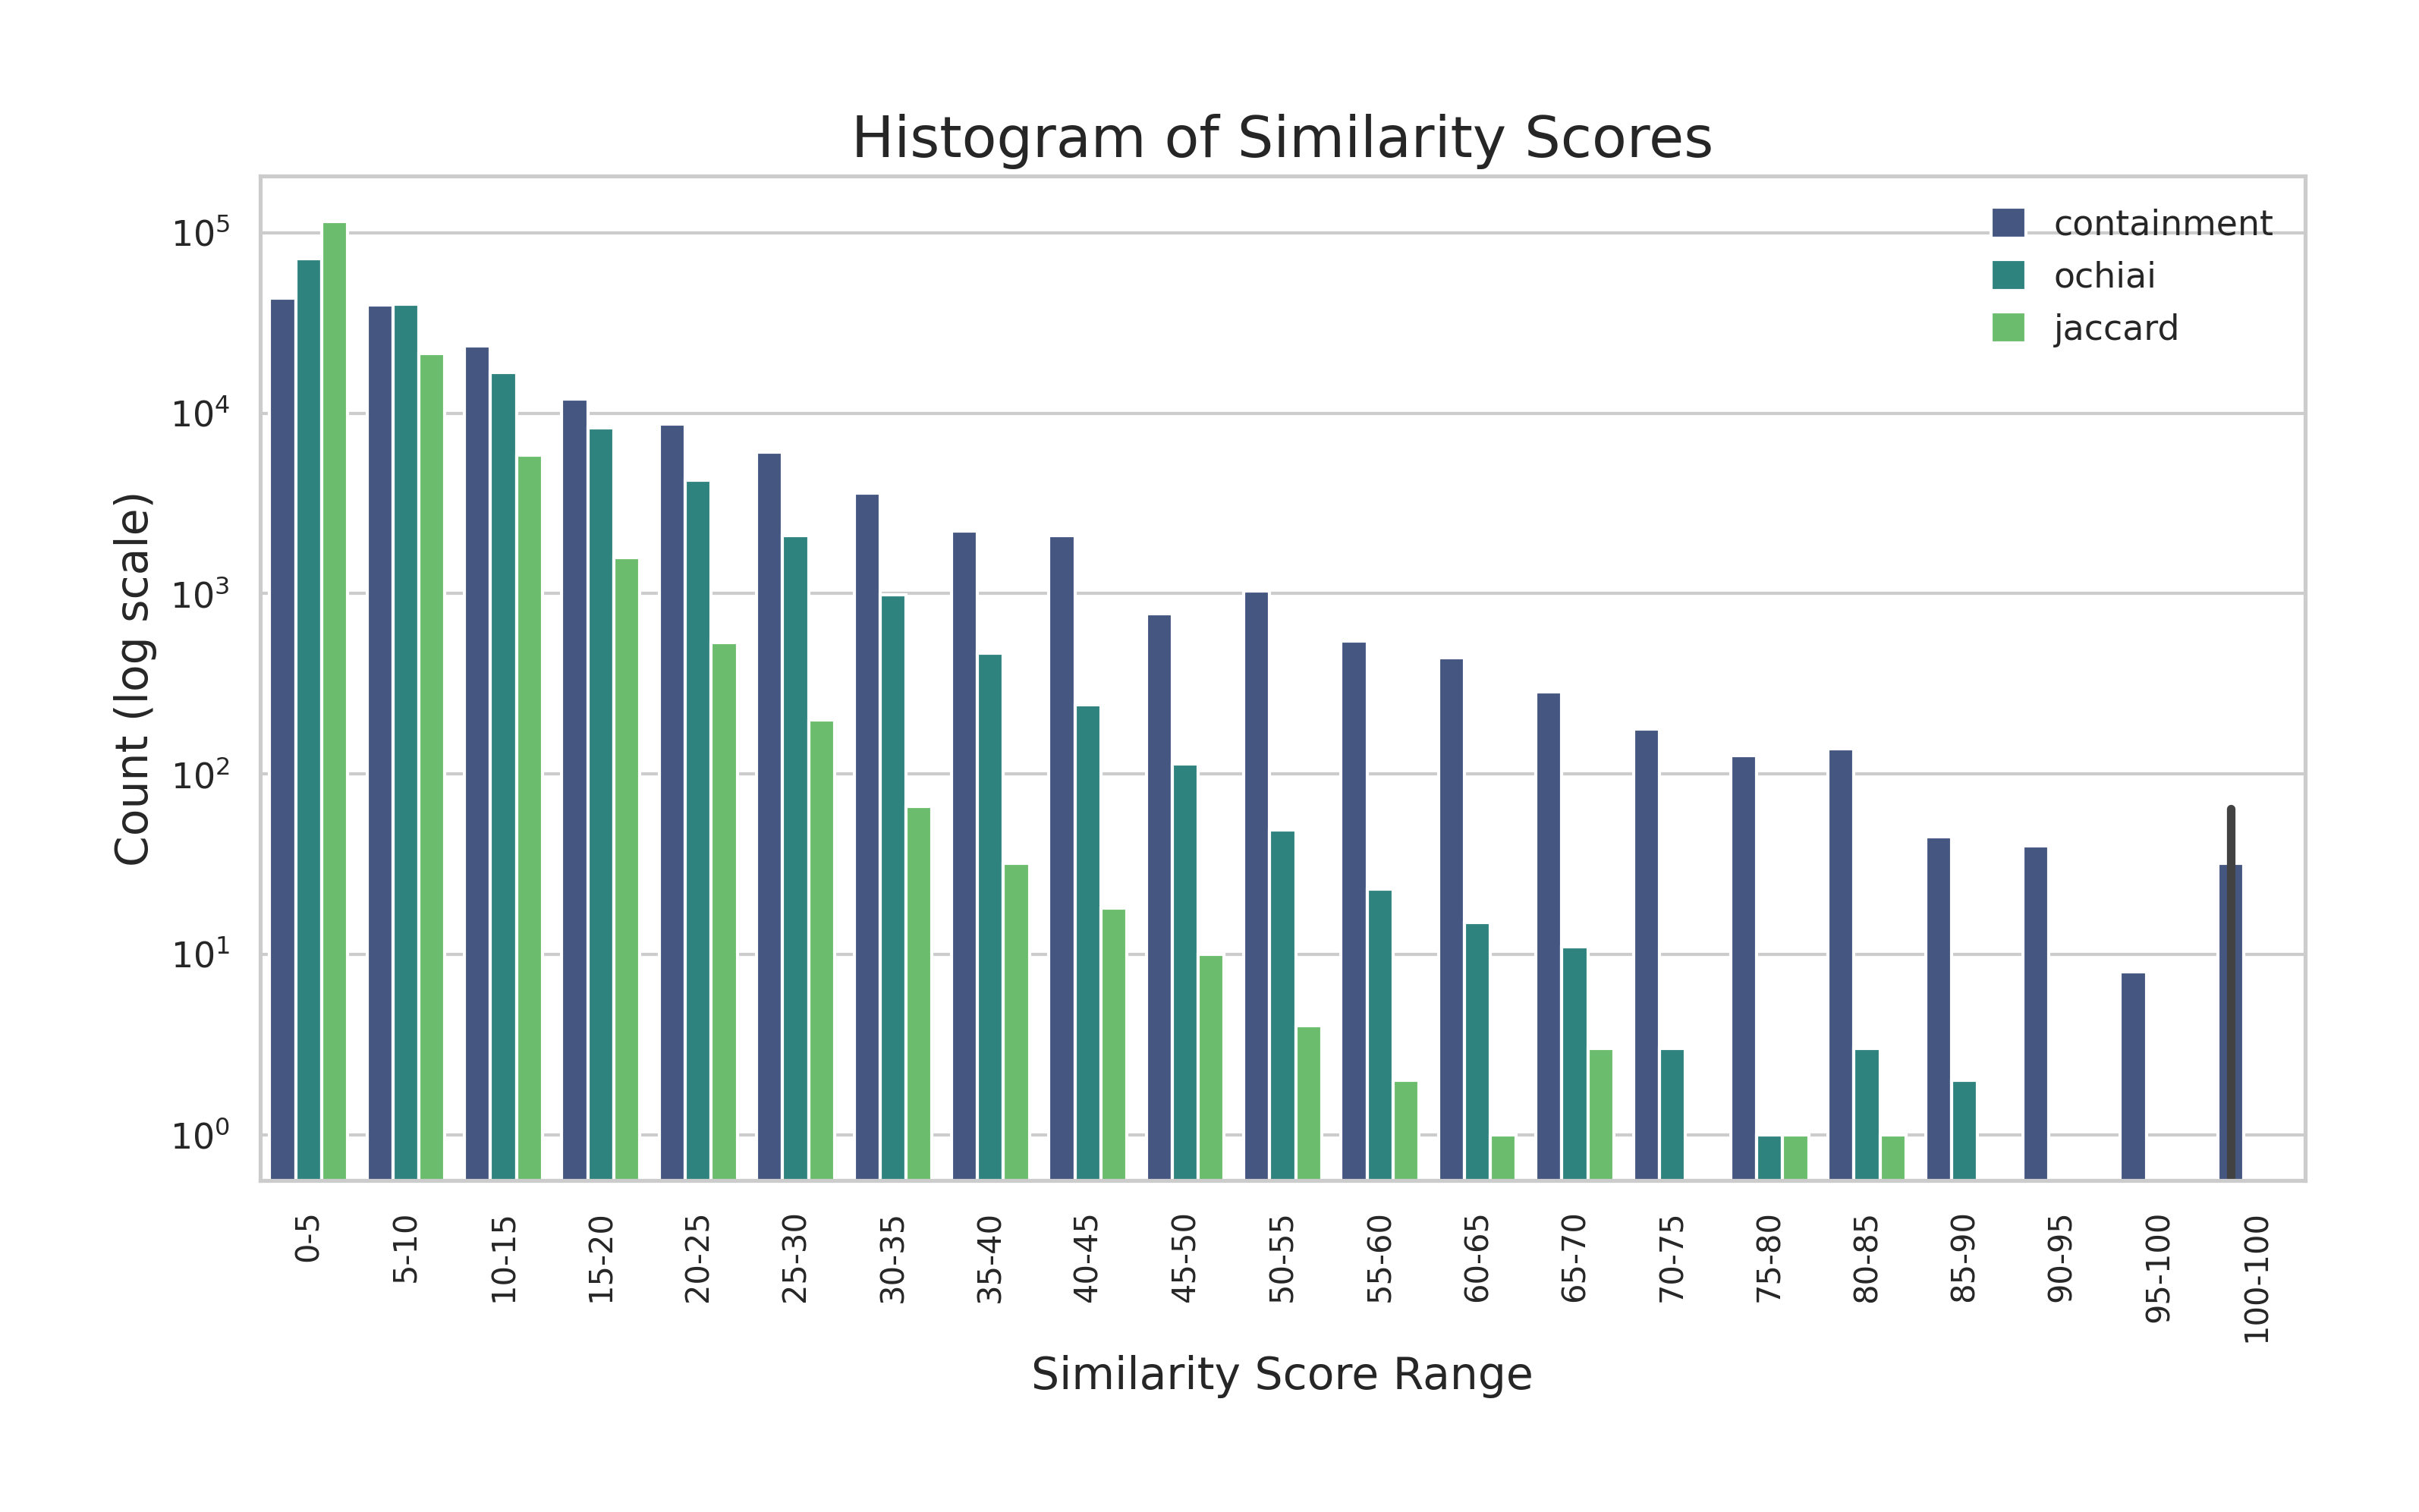

In [22]:
print_json("bipartite_pid/bipartite_pid_similarity_metrics_histogram.json")

Image(filename='bipartite_pid/bipartite_pid_similarity_metrics_histogram_log.png')

### KEGG vs all databases minus KEGG

Metric: containment
{'0-5': 28464.0, '5-10': 21275.0, '10-15': 13750.0, '15-20': 8165.0, '20-25': 6347.0, '25-30': 4741.0, '30-35': 3083.0, '35-40': 2095.0, '40-45': 2173.0, '45-50': 913.0, '50-55': 1268.0, '55-60': 642.0, '60-65': 730.0, '65-70': 417.0, '70-75': 311.0, '75-80': 248.0, '80-85': 239.0, '85-90': 178.0, '90-95': 211.0, '95-100': 47.0, '100-100': 164.0}
Metric: ochiai
{'0-5': 47516.0, '5-10': 23108.0, '10-15': 11303.0, '15-20': 6248.0, '20-25': 3520.0, '25-30': 1715.0, '30-35': 863.0, '35-40': 400.0, '40-45': 259.0, '45-50': 176.0, '50-55': 106.0, '55-60': 70.0, '60-65': 52.0, '65-70': 38.0, '70-75': 22.0, '75-80': 22.0, '80-85': 16.0, '85-90': 11.0, '90-95': 9.0, '95-100': 7.0, '100-100': nan}
Metric: jaccard
{'0-5': 74860.0, '5-10': 14269.0, '10-15': 4124.0, '15-20': 1187.0, '20-25': 391.0, '25-30': 240.0, '30-35': 124.0, '35-40': 82.0, '40-45': 51.0, '45-50': 27.0, '50-55': 32.0, '55-60': 13.0, '60-65': 17.0, '65-70': 9.0, '70-75': 12.0, '75-80': 4.0, '80-85': 7.0, '85-

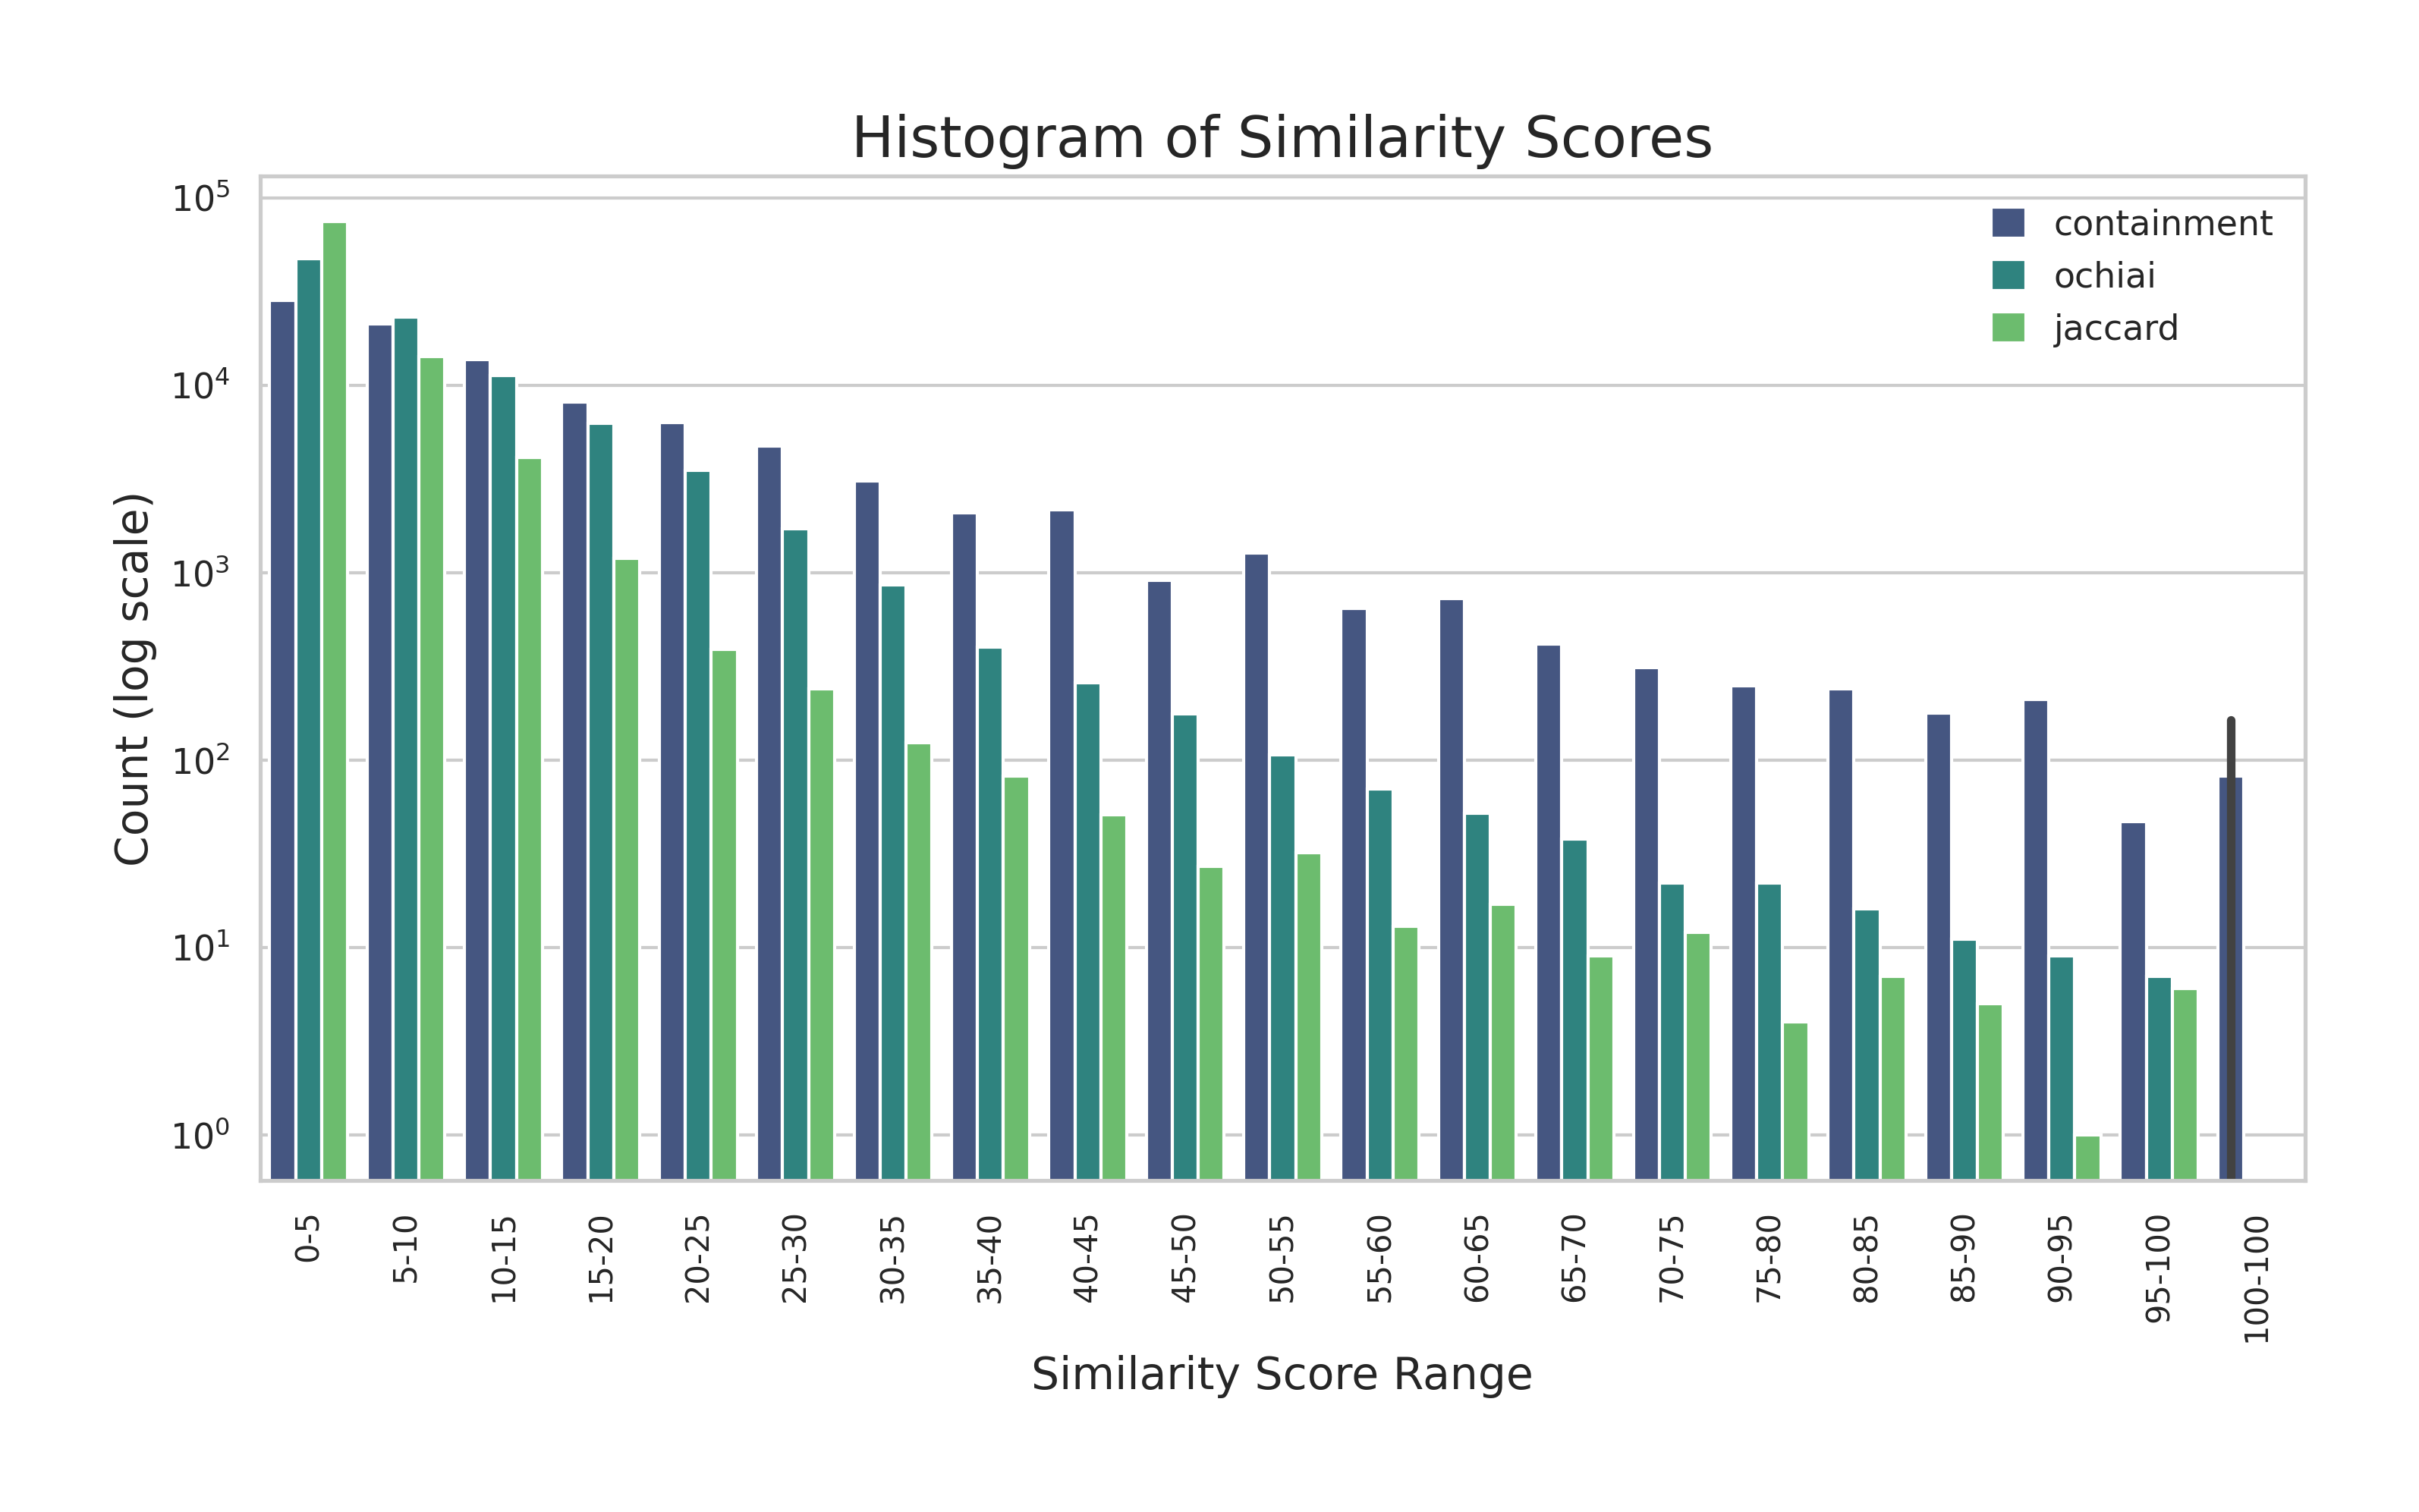

In [23]:
print_json("bipartite_kegg/bipartite_kegg_similarity_metrics_histogram.json")

Image(filename='bipartite_kegg/bipartite_kegg_similarity_metrics_histogram_log.png')

### Biocarta vs all databases minus Biocarta

Metric: containment
{'0-5': 14955, '5-10': 36632, '10-15': 26031, '15-20': 13092, '20-25': 9967, '25-30': 8366, '30-35': 5161, '35-40': 3209, '40-45': 3526, '45-50': 1342, '50-55': 2095, '55-60': 1025, '60-65': 913, '65-70': 497, '70-75': 418, '75-80': 257, '80-85': 253, '85-90': 147, '90-95': 88, '95-100': 9, '100-100': 100}
Metric: ochiai
{'0-5': 48822, '5-10': 40511, '10-15': 18465, '15-20': 9620, '20-25': 5195, '25-30': 2781, '30-35': 1380, '35-40': 599, '40-45': 367, '45-50': 157, '50-55': 78, '55-60': 50, '60-65': 21, '65-70': 15, '70-75': 4, '75-80': 4, '80-85': 3, '85-90': 4, '90-95': 5, '95-100': 1, '100-100': 1}
Metric: jaccard
{'0-5': 94857, '5-10': 23124, '10-15': 6838, '15-20': 2013, '20-25': 719, '25-30': 305, '30-35': 106, '35-40': 46, '40-45': 38, '45-50': 10, '50-55': 5, '55-60': 4, '60-65': 4, '65-70': 2, '70-75': 1, '75-80': 3, '80-85': 3, '85-90': 3, '90-95': 1, '95-100': 0, '100-100': 1}


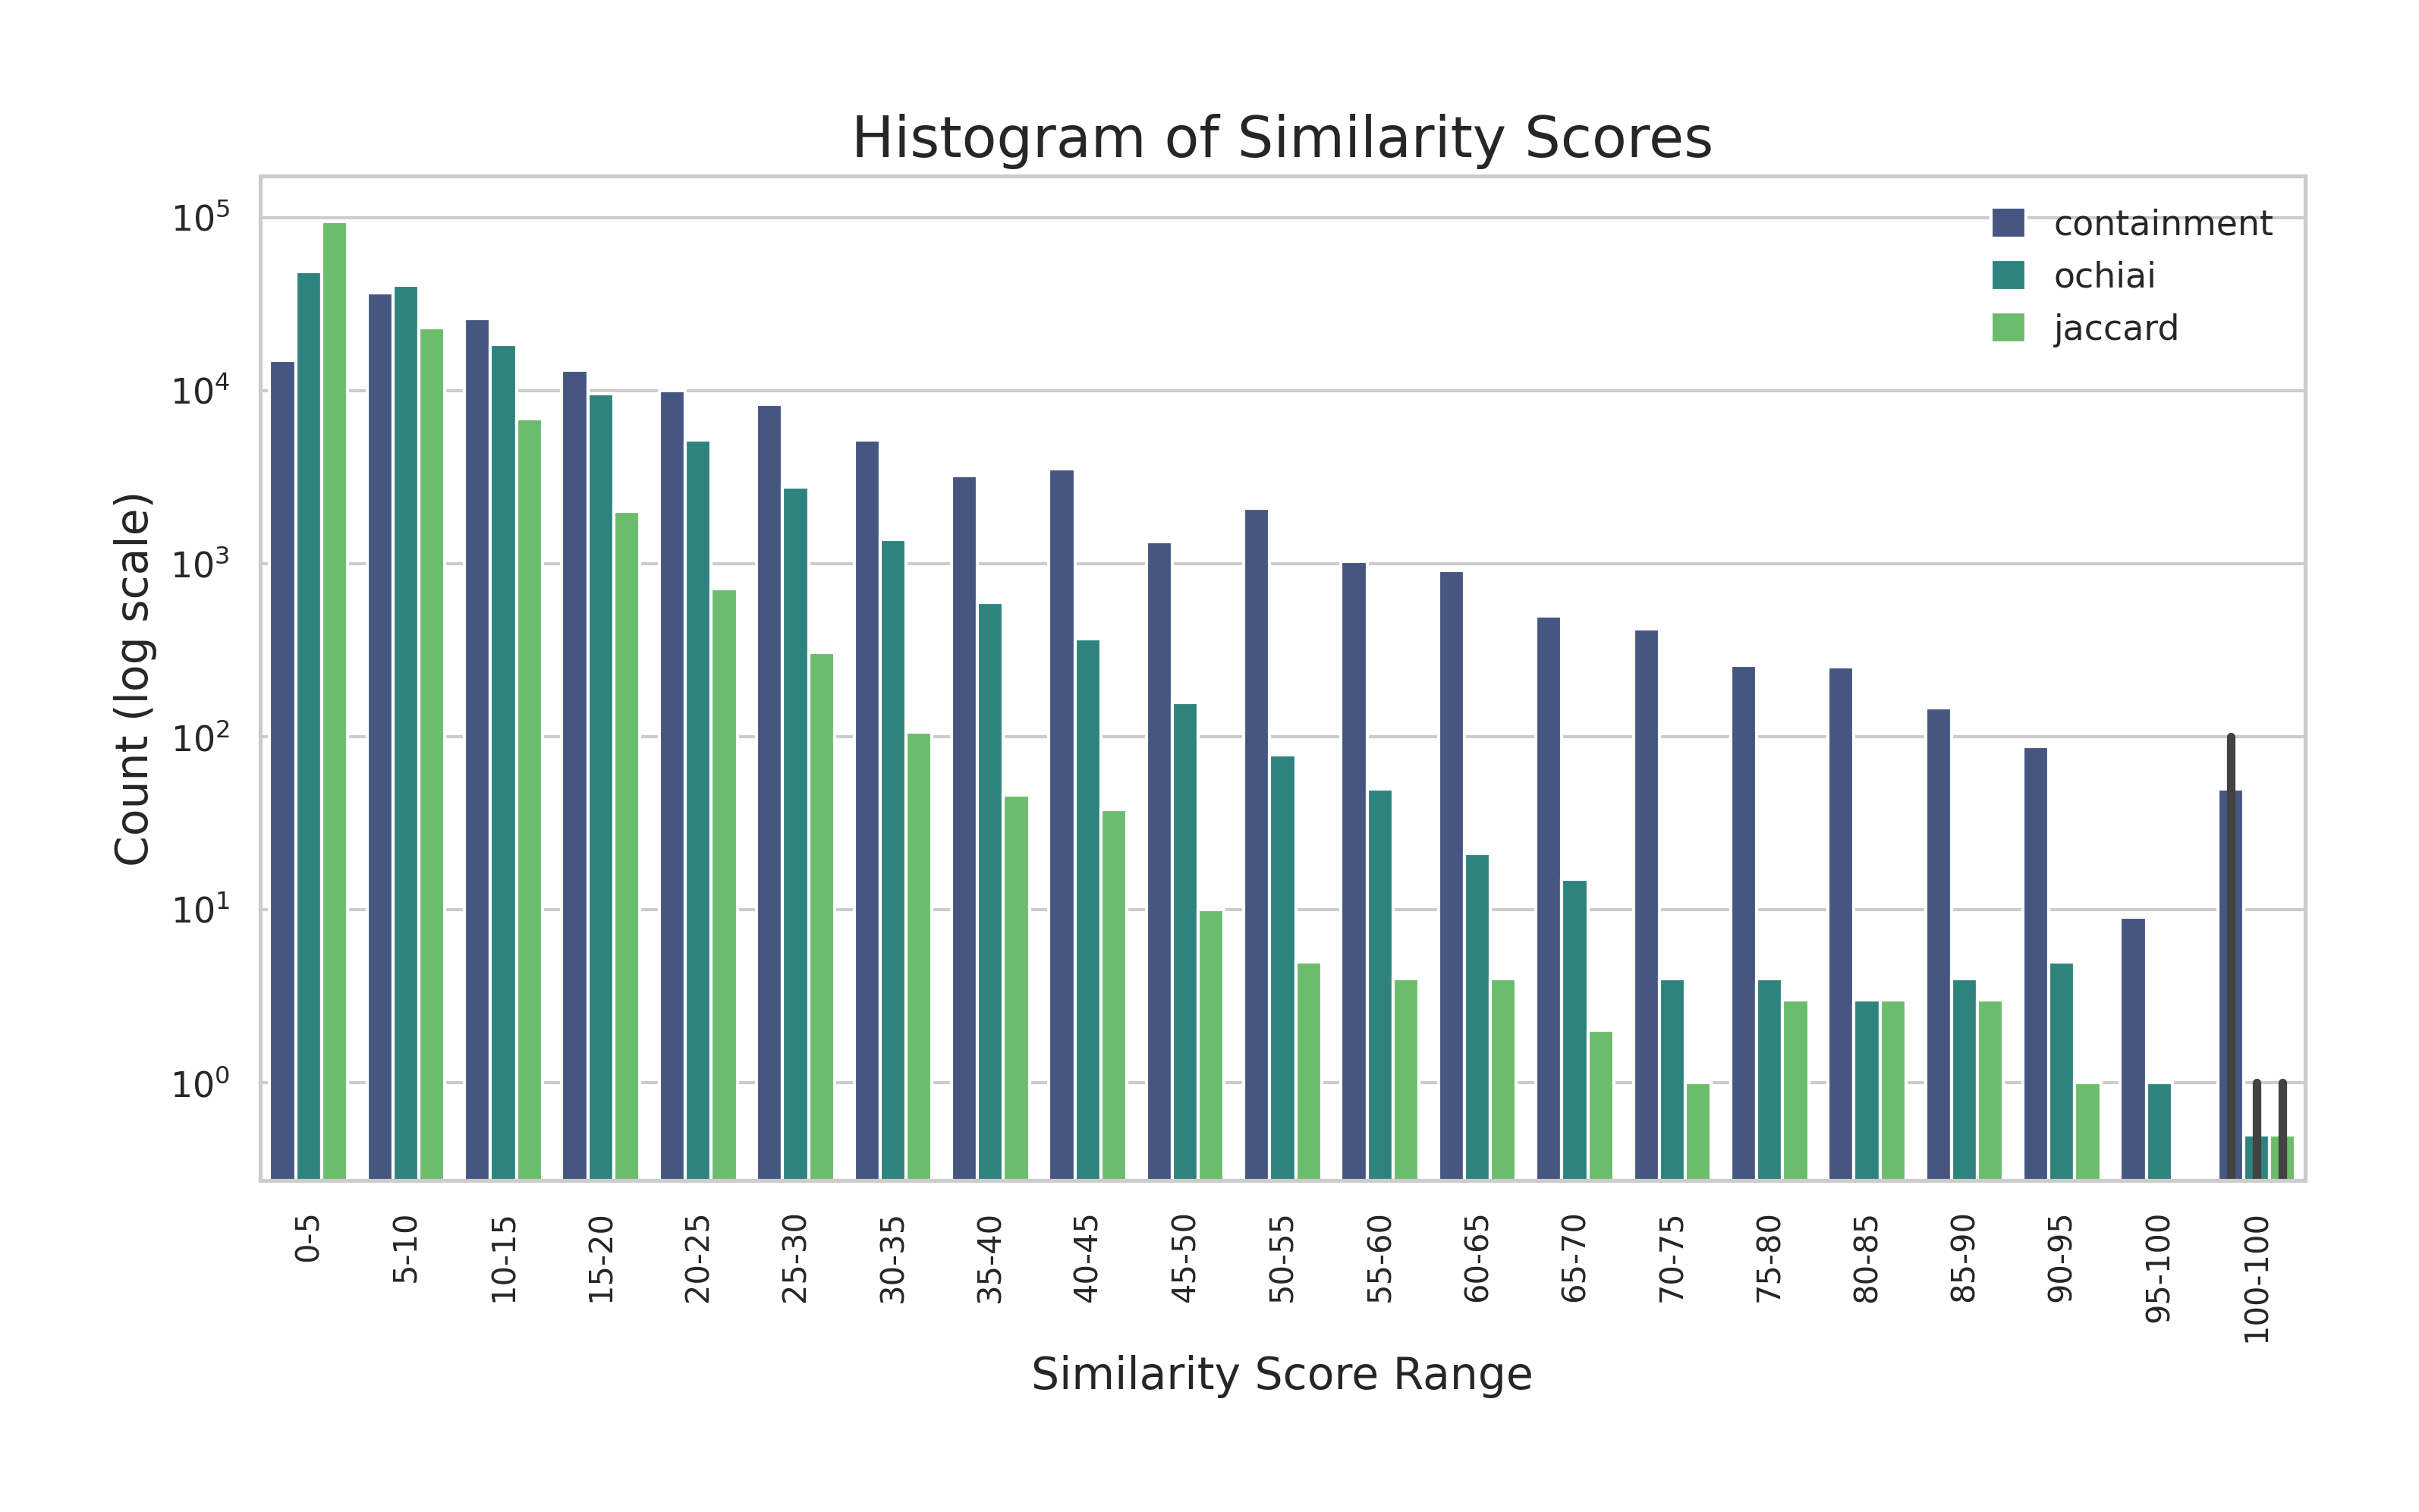

In [24]:
print_json("bipartite_biocarta/bipartite_biocarta_similarity_metrics_histogram.json")

Image(filename='bipartite_biocarta/bipartite_biocarta_similarity_metrics_histogram_log.png')

### Insights

Wikipathways: The notable counts fall in the high overlap ranges (80-100%), which means a significant number of pathways are very similar to those in other databases. In terms of Ochiai, the overlap is considerably less, with most scores falling below 30%. This suggests that while there are shared genes between pathways, the degree of similarity isn't as high as containment suggests.

Reactome: This database shows a similar pattern with a significant count in the high overlap ranges (80-100%). The Ochiai scores primarily fall below 30%, showing that while common genes exist, the similarity isn't as substantial.

PID: PID presents fewer overlaps in the high ranges compared to Wikipathways and Reactome. Ochiai scores are relatively lower, again demonstrating a lower degree of similarity between the pathways, even though there are shared genes.

KEGG: KEGG also displays fewer overlaps in the high ranges, which means it has some unique pathways that other databases lack. The Ochiai score distribution is similar to the previous databases, with most of the values falling below 30%.

Biocarta: This database presents fewer overlaps in the high ranges. However, it has a noticeable count in the moderate overlap ranges (40-50%). The Ochiai score distribution is relatively lower, with most values below 30%.

---

Our cross-database comparison of canonical pathways shows considerable overlap among various repositories, as assessed through containment and Ochiai metrics. Wikipathways and Reactome exhibit pronounced similarities, with a substantial proportion of their pathways falling within the high overlap ranges. This highlights a significant redundancy in their information. Conversely, PID, KEGG, and Biocarta databases present less overlap, indicating unique pathways contributing to their databases. These findings underline the necessity for researchers to judiciously select databases for pathway analysis, considering the potential bias induced by redundancy and uniqueness inherent in each database.